# Introduction to Machine Learning  
# Exercise Part 1 & 2

Some code cells will be marked with 
```
##########################
######## To Do ###########
##########################
```

This indicates that you are being asked to write a piece of code to complete the notebook.

# Part 1: The Linear Classifier

To illustrate the workflow for training a deep learning model in a supervised manner, this notebook will walk you through the simple case of training a linear classifier to recognize images various stages of the cell cycle. While deep learning might seem intimidating, don't worry. Its conceptual underpinnings are rooted in linear algebra and calculus - if you can perform matrix multiplication and take derivatives you can understand what is happening in a deep learning workflow.

In [1]:
import imageio as iio
import skimage
import sklearn.model_selection
import sklearn.utils
import sklearn.metrics
import sklearn.preprocessing
import skimage.color
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tqdm.auto

## The supervised machine learning workflow
Recall from class the conceptual workflow for a supervised machine learning project. 
- First, we create a <em>training dataset</em>, a paired collection of raw data and labels where the labels contain information about the "insight" we wish to extract from the raw data. 
- Once we have training data, we can then use it to train a <em>model</em>. The model is a mathematical black box - it takes in data and transforms it into an output. The model has some parameters that we can adjust to change how it performs this mapping. 
- Adjusting these parameters to produce outputs that we want is called training the model. To do this we need two things. First, we need a notion of what we want the output to look like. This notion is captured by a <em>loss function</em>, which compares model outputs and labels and produces a score telling us if the model did a "good" job or not on our given task. By convention, low values of the loss function's output (e.g. the loss) correspond to good performance and high values to bad performance. We also need an <em>optimization algorithm</em>, which is a set of rules for how to adjust the model parameters to reduce the loss
- Using the training data, loss function, and optimization algorithm, we can then train the model 
- Once the model is trained, we need to evaluate its performance to see how well it performs and what kinds of mistakes it makes. We can also perform this kind of monitoring during training (this is actually a standard practice).

Because this workflow defines the lifecycle of most machine learning projects, this notebook is structured to go over each of these steps while constructing a linear classifier.


## Create training data
The starting point of every machine learning project is data. Today we are going to look at a collection of images of Jurkat cells published in the Broad Bioimage Collection ([BBBC048](https://bbbc.broadinstitute.org/BBBC048)). The cells were fixed and stained with PI (propidium iodide) to quantify DNA content and a MPM2 (mitotic protein monoclonal #2) antibody to identify mitotic cells.

During the initial setup of this exercise, we downloaded the data and unzipped the relevant files using the script `data-download.sh`.

In [2]:
data_dir = 'data/CellCycle'
os.listdir(data_dir)

['Metaphase',
 '66.lst~',
 'Anaphase',
 'G1',
 'Telophase',
 'Prophase',
 'S',
 'G2',
 'img.lst~',
 'img.lst']

The command above should generate the following output. If you see something different, please check that the `data-download.sh` script ran correctly.
```
['img.lst~',
 'Anaphase',
 'Prophase',
 'img.lst',
 'S',
 '66.lst~',
 'G1',
 'Metaphase',
 'G2',
 'Telophase']
 ```
 
The metadata for each file is stored in `img.lst` so we will first load this information to inform how we load the rest of the dataset.

In [3]:
# Load dataframe with sample info
df = pd.read_csv(os.path.join(data_dir, 'img.lst'), sep='\t', header=None)
df = df.rename(columns={1: 'class', 2: 'filepath'})
df['channel'] = df['filepath'].str.split('/',expand=True)[2].str.split('_', expand=True)[1].str.slice(2,3)
df['id'] = df['filepath'].str.split('/',expand=True)[2].str.split('_', expand=True)[0]
df.head()

,0,class,filepath,channel,id
0,19,0,./Anaphase/12432_Ch3.ome.jpg,3,12432
1,8,0,./Anaphase/12432_Ch4.ome.jpg,4,12432
2,35,0,./Anaphase/12432_Ch6.ome.jpg,6,12432
3,36,0,./Anaphase/22004_Ch3.ome.jpg,3,22004
4,1,0,./Anaphase/22004_Ch4.ome.jpg,4,22004


In [4]:
df['class'].unique()

array([0, 4, 5, 1, 2, 6, 3])

For each `id` there are three images. One for each of the channels: phase, PI and MPM2. We will load each image and stack it into an array of training data.

In [5]:
# Load data stack
ims = []
ys = []
for i, g in df.groupby('id'):
    im = []
    for _, r in g.iterrows():
        im.append(iio.imread(os.path.join(data_dir, r['filepath'])))
    ims.append(np.stack(im, axis=-1))
    ys.append(r['class'])
    
X_data = np.stack(ims)
y_data = np.stack(ys)
print('X shape:', X_data.shape)
print('y shape:', y_data.shape)

/var/folders/cz/1rzgr7p564q00vylf6hzyrgh0000gn/T/ipykernel_48168/2396819062.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im.append(iio.imread(os.path.join(data_dir, r['filepath'])))


X shape: (32266, 66, 66, 3)
y shape: (32266,)


In the previous cell, you probably observed that there are 4 dimensions rather than the 3 you might have been expecting. This is because while each image is (66, 66, 3), the full dataset has many images. The different images are stacked along the first dimension. The full size of the training images is (# images, 66, 66, 3) - the first dimension is often called the batch dimension.

#### Task 1.1

In [6]:
##########################
######## To Do ###########
##########################

# Use matplotlib (plt.imshow) to visualize several images randomly drawn from the dataset
# There are 6 classes in the dataset. Make sure to look at an example or each class


### Checking Class Balance

Let's check the balance of classes in this dataset. There are at least two ways you could do this. One would be to use matplotlib to create a histogram. The other would be to count the number of items in each class using numpy.

#### Task 1.2

In [8]:
##########################
######## To Do ###########
##########################

# Add your code to check class balances here
# You should end up with a count of number of items in each of the 7 classes

This dataset is highly inbalanced so we will want to correct the class balance before training. We will resample the data after splitting it below. We can improve the balance of samples by upsampling the minority class to match the number of samples in the majority class using [`sklearn.utils.resample`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html).

### Extract classes of interest

Initially, we are going to restrict the dataset to two classes `[4, 5]` and a single channel `0`.

In [10]:
def extract_classes(X_data, y_data, classes):
    """For a given dataset of categorical labels, this data
    selects the datapoints associated with the classes of interest
    and returns them stacked in a new array
    
    Args:
        X_data (np.array): Array of x data
        y_data (np.array): Array of categorical y data
        classes (list): List of categorical classes to select
        
    Returns:
        np.array: X data after extracting the classes of interest 
        np.array: y data after selecting the classes of interest
    """
    X, y = [], []
    for c in classes:
        # Identify the indicies of the relevant class
        idx = y_data == c
        # Select the X and y data accordingly
        X.append(X_data[idx, ..., 0:1])
        y.append(y_data[idx])

    # Restack the arrays
    X = np.concatenate(X)
    y = np.concatenate(y)
    return X, y

In [11]:
X, y = extract_classes(X_data, y_data, [4, 5])

print(X.shape, y.shape)

(22934, 66, 66, 1) (22934,)


We will also reassign classes 4 and 5 to 0 and 1 for simplicity.

In [12]:
y[y == 4] = 0
y[y == 5] = 1

For this exercise, we will want to flatten the training data into a vector

In [13]:
# Record the original width so that we can use this for reshaping later
image_width = X_data[0].shape[0]
image_width

66

In [14]:
# Flatten the images 1d vectors
X = np.reshape(X, (-1, image_width * image_width, 1))
print(X.shape)

(22934, 4356, 1)


### Split the training dataset into training and testing datasets
How do we know how well our model is doing? A common practice to evaluate models is to evaluate them on splits of the original training dataset. Splitting the data is important, because we want to see how models perform on data that was not used to train them.
- The <em>training</em> dataset used to train the model
- A held out <em>testing</em> dataset used to evaluate the final trained version of the model
While there is no hard and fast rule, 80%/20% splits are a reasonable starting point.

In [15]:
# Split the dataset into training, validation, and testing splits
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.8, shuffle=True)

### Correct class imbalance

#### Task 1.3

Write a function to increase the number of samples in the minority class to match the number of samples in the majority class. Your function should take in the X and y arrays and return X and y arrays after upsampling. Make sure to shuffle the data before returning it to restore a randomized order.

In [16]:
##########################
######## To Do ###########
##########################

def balance_classes(X, y, minority_id):
    """For a given minority class id, upsample the minority class
    to match the number of samples in the majority class
    
    Args:
        X (np.array): Array of raw data
        y (np.array): Array of class labels
        minority_id (int): Integer of the minority class to be upsampled
        
    Returns:
        np.array: X
        np.array: y
    """
    # Split the X and y arrays into sub arrays containing 
    # 1) only the minority samples and 2) the remaining samples
    
    # Use sklearn.utils.resample to samples from the minority sample array 
    # to match the number of samples in the second array
    
    # Concatenate the upsampled array 1 with the remaining array 2
    
    # Shuffle the concatenated arrays
    
    return X, y

In [18]:
X_train, y_train = balance_classes(X_train, y_train, 1)
X_test, y_test = balance_classes(X_test,  y_test, 1)
print('Train shape:', X_train.shape,  y_train.shape)
print('Test shape:', X_test.shape, y_test.shape)

Train shape: (22974, 4356, 1) (22974,)
Test shape: (5692, 4356, 1) (5692,)


## The linear classifier
The linear classifier produces class scores that are a linear function of the pixel values. Mathematically, this can be written as $\vec{y} = W \vec{x}$, where $\vec{y}$ is the vector of class scores, $W$ is a matrix of weights and $\vec{x}$ is the image vector. The shape of the weights matrix is determined by the number of classes and the length of the image vector. In this case $W$ is 2 by 4356. Our learning task is to find a set of weights that maximize our performance on our classification task. We will solve this task by doing the following steps
- Randomly initializing a set of weights
- Defining a loss function that measures our performance on the classification task
- Use stochastic gradient descent to find "optimal" weights

### Create the matrix of weights
Properly initializing weights is essential for getting deep learning methods to work correctly. We are going to start with weights initizalized with zeros, but will invesigate other methods later in the exercise.

Lets create the linear classifier using object oriented programming, which will help with organization. 

In [19]:
class LinearClassifier(object):
    def __init__(self, image_size=image_width * image_width, n_classes=2):
        self.image_size = image_size
        self.n_classes = n_classes
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):  
        self.W = np.zeros((self.n_classes, self.image_size))

### Apply the softmax transform to complete the model outputs
Our LinearClassifier class needs a method to perform predictions - which in our case is performing matrix multiplication and then applying the softmax transform.  The softmax functions transforms a vector of arbitrary real numbers and turns it into probabilities that we can use for our final prediction.

![](https://miro.medium.com/max/1400/1*gctBX5YHUUpBEK3MWD6r3Q.png)
(*Image by [Thomas Kurbiel](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)*)

There is an excellent [derivation of the softmax function](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1) available on Towards Data Science if you are interested in the details of the math.

#### Task 1.4

In [20]:
##########################
######## To Do ###########
##########################

# Complete the predict function below to predict a label y from an input X
# Note that our predict function is going to start by removing the channel dimension from the X data.
# Pay careful attention to the shape of your data at each step

def predict(self, X, epsilon=1e-5):
    X = X[..., 0]
    pass
    #y = # matrix multiplication

    #y = # Apply softmax
    return y

# Assign methods to class
setattr(LinearClassifier, 'predict', predict)

## Stochastic gradient descent
To train this model, we will use stochastic gradient descent. In its simplest version, this algorithm consists of the following steps:
- Select several images from the training dataset at random
- Compute the gradient of the loss function with respect to the weights, given the selected images
- Update the weights using the update rule $\Delta W_{ij} \rightarrow \Delta W_{ij} - lr\frac{\partial loss}{\partial W_{ij}}$

Recall that the origin of this update rule is from multivariable calculus - the gradient tells us the direction in which the loss function increases the most. So to minimize the loss function we move in the opposite direction of the gradient.

Also recall from the course notes that for this problem we can compute the gradient analytically. The gradient is given by

\begin{equation}
\frac{\partial loss}{\partial W_{ij}} = \left(p_i - 1(i \mbox{ is correct}) \right)x_j,
\end{equation}
where $1$ is an indicator function that is 1 if the statement inside the parentheses is true and 0 if it is false.

A complete derivation of $\frac{\partial loss}{\partial W_{ij}}$ is included in the Towards Data Science [article](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1) recommended above if you are interested in the details.

In [22]:
def grad(self, X, y):
    # Get class probabilities
    p = self.predict(X)
    
    # Compute class 0 gradients
    temp_0 = np.expand_dims(p[...,0] - (1-y), axis=-1)
    grad_0 = temp_0 * X[...,0]

    # Compute class 1 gradients
    temp_1 = np.expand_dims(p[...,1] - y, axis=-1)
    grad_1 =  temp_1 * X[...,0]
    
    gradient = np.stack([grad_0, grad_1], axis=1)
    
    return gradient
    
def loss(self, X, y_true):
    y_pred = self.predict(X)
    
    # Convert y_true to one hot
    y_true = np.stack([y_true, 1-y_true], axis=-1)
    loss = np.mean(-y_true * np.log(y_pred))
    
    return loss
    
def fit(self, X_train, y_train, n_epochs, batch_size=1, learning_rate=1e-5):
    loss_list = []
    
    # Iterate over epochs
    for epoch in range(n_epochs):
        n_batches = int(np.floor(X_train.shape[0] / batch_size))
        
        # Generate random index
        index = np.arange(X_train.shape[0])
        np.random.shuffle(index)
        
        # Iterate over batches
        for batch in range(n_batches):
            beg = batch*batch_size
            end = (batch+1)*batch_size if (batch+1)*batch_size < X_train.shape[0] else -1
            X_batch = X_train[beg:end]
            y_batch = y_train[beg:end]
            
            # Compute the loss
            loss = self.loss(X_batch, y_batch)
            loss_list.append(loss)
            
            # Compute the gradient
            gradient = self.grad(X_batch, y_batch)
            
            # Compute the mean gradient over all the example images
            gradient = np.mean(gradient, axis=0, keepdims=False)

            # Update the weights
            self.W -= learning_rate * gradient
            
    return loss_list

# Assign methods to class
setattr(LinearClassifier, 'grad', grad)
setattr(LinearClassifier, 'loss', loss)
setattr(LinearClassifier, 'fit', fit)

Before we train the model, let's take a brief moment to check what the untrained model predictions look like.

In [23]:
lc = LinearClassifier()

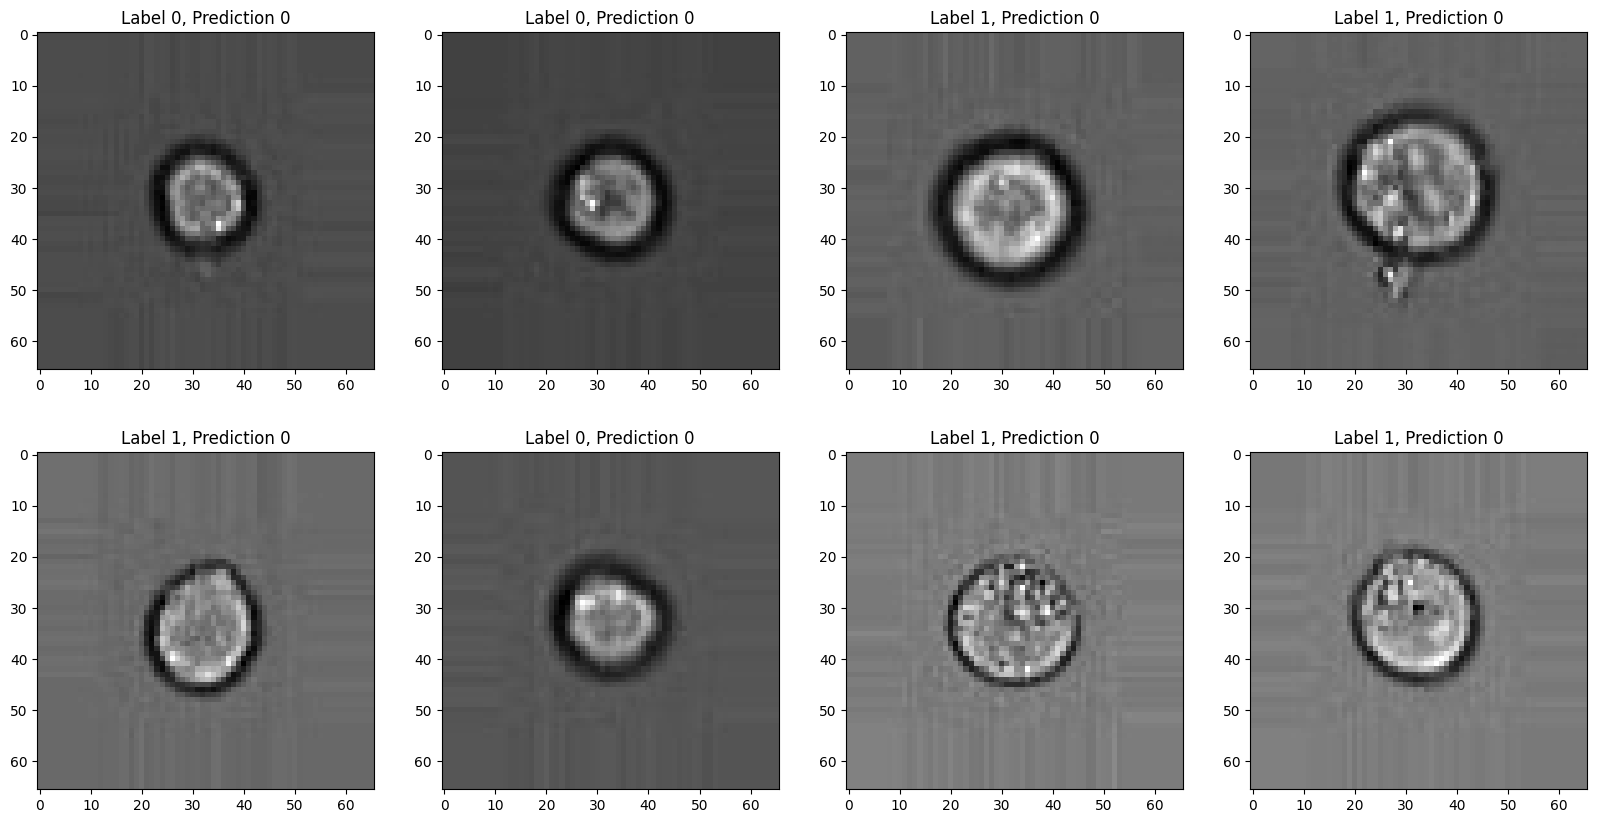

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(20,10))
for i, j in enumerate(np.random.randint(X_test.shape[0], size=(8,))):
    
    # Get an example image
    X_sample = X_test[j,...]
    
    # Reshape flattened vector to image
    X_reshape = np.reshape(X_sample, (66, 66))
    
    # Predict the label
    y_pred = lc.predict(X_sample)
    
    # Display results
    axes.flatten()[i].imshow(X_reshape, cmap='gray')
    axes.flatten()[i].set_title('Label ' + str(y_test[j]) +', Prediction ' + str(np.argmax(y_pred)))

In addition to inspecting the results of individual predictions, we can also look at summary statistics that capture model performance.

In [25]:
def benchmark_performance(y_true, y_pred):
    """Calculates recall, precision, f1 and a confusion matrix for sample predictions
    
    Args:
        y_true (list): List of integers of true class values
        y_pred (list): List of integers of predicted class value
            
    Returns:
        dict: Dictionary with keys `recall`, `precision`, `f1`, and `cm`
    
    """
    _round = lambda x: round(x, 3)
    
    metrics = {
        'recall': _round(sklearn.metrics.recall_score(y_true, y_pred)),
        'precision': _round(sklearn.metrics.precision_score(y_true, y_pred)),
        'f1': _round(sklearn.metrics.f1_score(y_true, y_pred)),
        'cm': sklearn.metrics.confusion_matrix(y_true, y_pred, normalize=None),
        'cm_norm': sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='true')
    }
    
    return metrics

#### Task 1.5
For each of the 4 metrics above, describe in your own words what this metric tells you about model performance.

########################  
######## To Do ###########  
########################  

- Recall
- Precision
- F1
- Confusion Matrix

In [26]:
def plot_metrics(metrics, name, ax=None):
    """Plots a confusion matrix with summary statistics listed above the plot
    
    The annotations on the confusion matrix are the total counts while
    the colormap represents those counts normalized to the total true items
    in that class.
    
    Args:
        metrics (dict): Dictionary output of `benchmark_performance`
        name (str): Title for the plot
        ax (optional, matplotlib subplot): Subplot axis to plot onto. 
            If not provided, a new plot is created
        classes (optional, list): A list of the classes to label the X and y 
            axes. Defaults to [0, 1] for a two class problem.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    cb = ax.imshow(metrics['cm_norm'], cmap='Greens', vmin=0, vmax=1)
    
    classes = np.arange(metrics['cm'].shape[0])
    plt.xticks(range(len(classes)), classes)
    plt.yticks(range(len(classes)), classes)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            color='green' if metrics['cm_norm'][i,j] < 0.5 else 'white'
            ax.annotate('{}'.format(metrics['cm'][i,j]), (j, i),
                        color=color, va='center', ha='center')

    _ = plt.colorbar(cb, ax=ax)
    _ = ax.set_title(
            '{}\n'\
            'Recall: {}\n'\
            'Precision: {}\n'\
            'F1 Score: {}\n'\
            ''.format(name, metrics['recall'], metrics['precision'], metrics['f1'])
        )

/Users/morganschwartz/opt/anaconda3/envs/01_intro_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


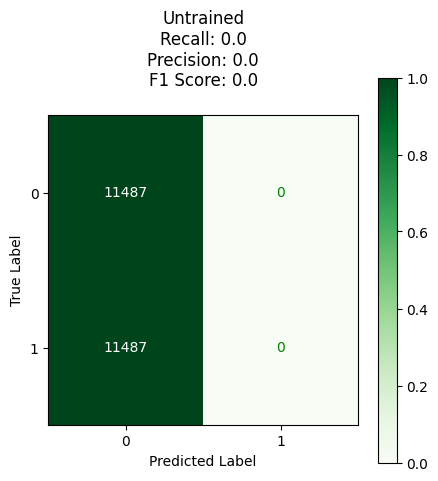

In [27]:
# Generate predictions and metrics for training data
y_pred = lc.predict(X_train)
y_pred = np.argmax(y_pred, axis=-1)

metrics = benchmark_performance(y_train, y_pred)

plot_metrics(metrics, 'Untrained')

#### Task 1.6
What do you notice about the initial results of the model? 

########################  
######## To Do ###########  
########################  

Let's train the model and compare the performance after training.

In [28]:
%%time
loss = lc.fit(X_train, y_train, n_epochs=32, batch_size=16)

CPU times: user 22.3 s, sys: 247 ms, total: 22.6 s
Wall time: 22.6 s


### Evaluate the model

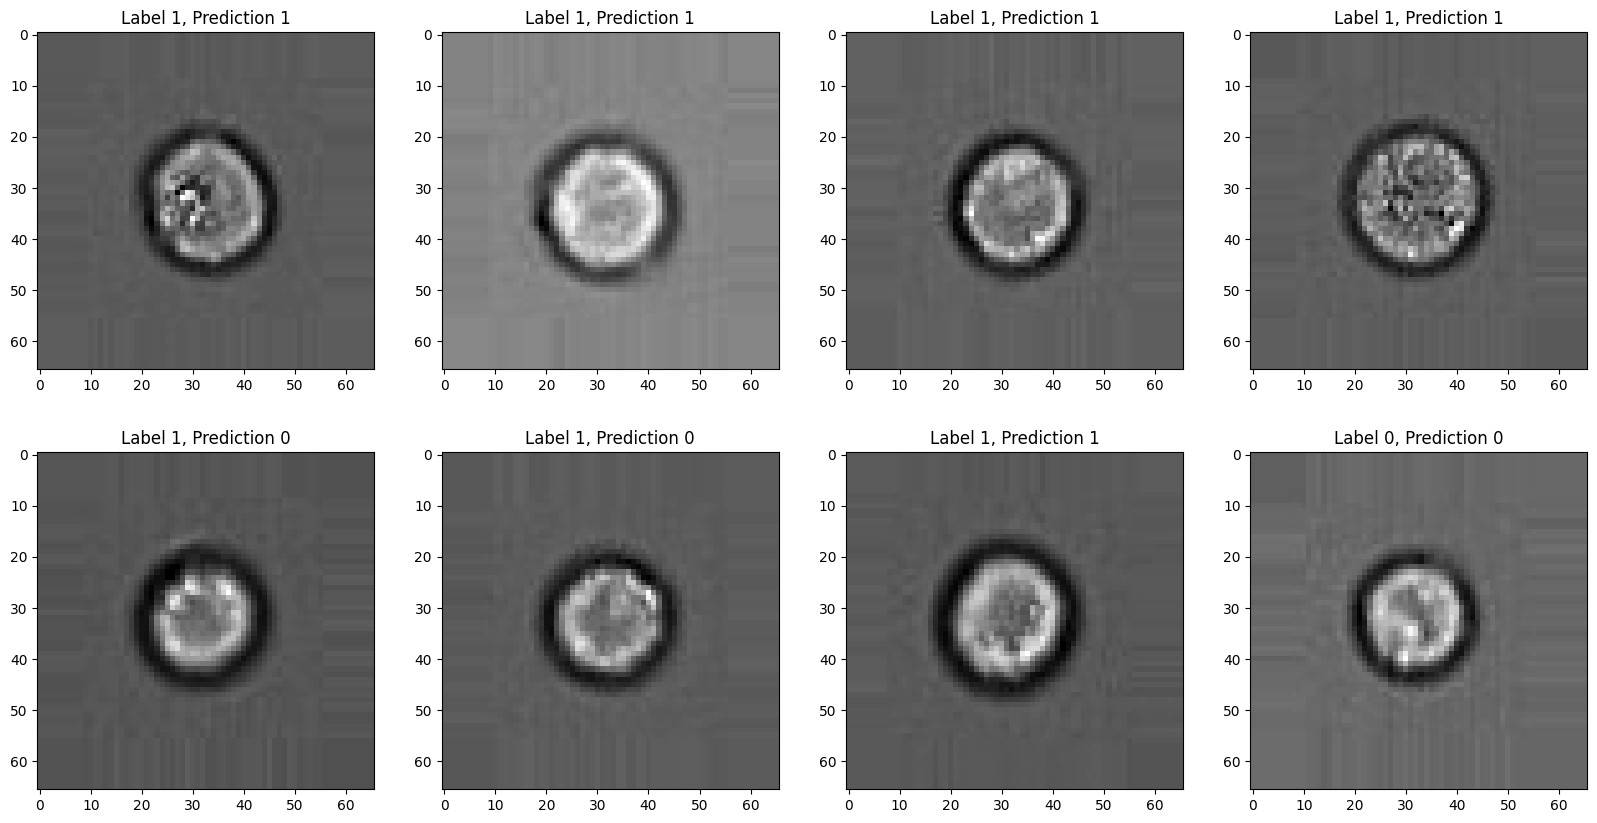

In [29]:
# Visualize some predictions

fig, axes = plt.subplots(2, 4, figsize=(20,10))
for i, j in enumerate(np.random.randint(X_test.shape[0], size=(8,))):
    
    # Get an example image
    X_sample = X_test[j]
    
    # Reshape flattened vector to image
    X_reshape = np.reshape(X_sample, (66, 66))
    
    # Predict the label
    y_pred = lc.predict(X_sample)
    
    # Display results
    axes.flatten()[i].imshow(X_reshape, cmap='gray')
    axes.flatten()[i].set_title('Label ' + str(y_test[j]) +', Prediction ' + str(np.argmax(y_pred)))

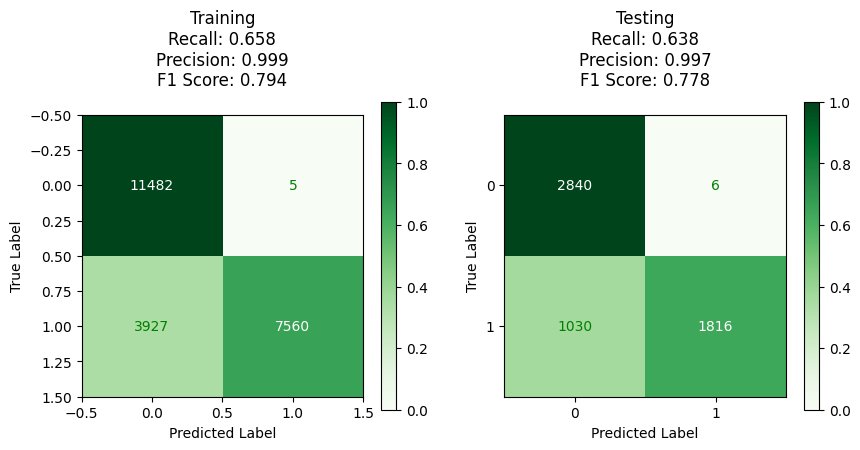

In [30]:
# Generate predictions and metrics for training data
y_pred = lc.predict(X_train)
y_pred = np.argmax(y_pred, axis=-1)
train_metrics = benchmark_performance(y_train, y_pred)

# Generate predictions and metrics for test data
y_pred = lc.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
test_metrics = benchmark_performance(y_test, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plot_metrics(train_metrics, 'Training', ax[0])
plot_metrics(test_metrics, 'Testing', ax[1])

#### Task 1.7

What do you notice about the results after training the model?

########################  
######## To Do ###########  
########################  

# Part 2: Implementing a linear classifier with TensorFlow
In this section, we will define our machine learning models using TensorFlow. These models are composed of layers - each layer specifies a mathematical operation that is applied to its input. The nice thing about TensorFlow is that almost all of the machinery required for stochastic gradient descent is taken care of for us.
- Specify trainable variables? Check.
- Initialize trainable variables with random values? Check.
- Compute the layer outputs? Check.
- Compute gradients using backpropagation? Check.
- Perform all of the computations on GPUs to speed up training and inference? Check.
All of the above (and more) are taken care of for us by TensorFlow - writing models often requires little math (although one practice that I encourage is keeping track of the input and output dimensions for each layer).

To define a linear classifier, we will use a module in TensorFlow called Keras. Keras simple APIs for specifying models. In Keras, there are two different APIs you can use:
- [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) - If your model is composed of a linear sequence of steps, this is the easier API to use.
- [Functional API](https://www.tensorflow.org/guide/keras/functional) - If your model is more complicated, this API provides more flexibility. If you're using the functional API, consider using a class with methods to write submodels.
The TensorFlow documentation provides additional details about how to use each of these two APIs.

In [31]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
        
import tensorflow_addons as tfa

from tensorflow.keras.layers import Input, Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPool2D, Softmax
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

## Create dataset object
TensorFlow uses Dataset objects to feed data into the training pipeline. In this section, we will write a function to assemble Dataset objects after splitting the data and balancing classes as needed.

In [32]:
def build_dataset(X, y, batch_size=1):
    # Create train/test/val splits
    X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(X, y, train_size=0.8)
    X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, train_size=0.5)
    
    # Balance classes in each split
    X_train, y_train = balance_classes(X_train, y_train, 1)
    X_test, y_test = balance_classes(X_test, y_test, 1)
    X_val, y_val = balance_classes(X_val, y_val, 1)
    
    # Convert y data to categorical
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    y_val = tf.keras.utils.to_categorical(y_val)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    train_dataset = train_dataset.shuffle(256).batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
    
    return {
        'train': train_dataset,
        'test': test_dataset,
        'val': val_dataset
    }

In [33]:
X, y = extract_classes(X_data, y_data, [4, 5])
y[y == 4] = 0
y[y == 5] = 1

with tf.device('CPU:0'):
    dataset = build_dataset(X, y, batch_size=64)

2022-08-25 23:51:35.720058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(64, 66, 66, 1)


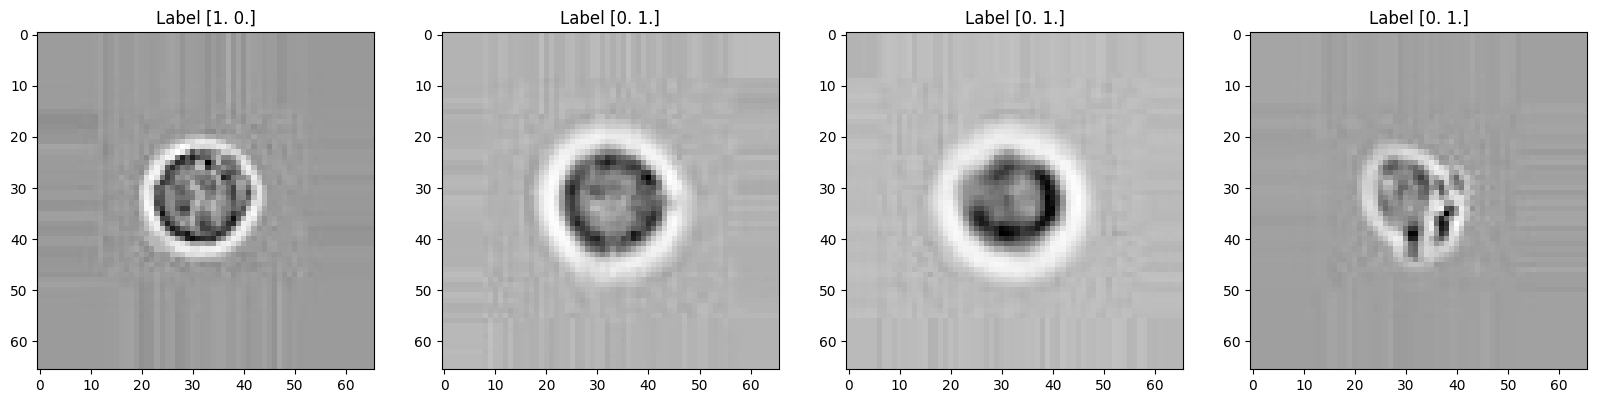

In [34]:
# Check the dataset builder
it = dataset['train'].as_numpy_iterator()
X_temp, y_temp = it.next()
print(X_temp.shape)

fig, axes = plt.subplots(1, 4, figsize=(20,10))
for i in range(4):
    axes.flatten()[i].imshow(X_temp[i,...,:], cmap='Greys')
    axes.flatten()[i].set_title('Label ' + str(y_temp[i]))

### Define the model

In [35]:
# Define the linear classifier
def create_linear_classifier():
    inputs = Input((X.shape[1], X.shape[2], 1),
                   name='linear_classifier_input')
    x = Flatten()(inputs)
    x = Dense(2)(x)
    x = Softmax(axis=-1)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

linear_classifier = create_linear_classifier()

## Specify training parameters 
In this section, we will specify how we want to train the neural network. We will need to specify three things:
- The loss function: Because we are training a model for classification, we will use the categorical crossentropy
- The training algorithm: There are many flavors of stochastic gradient descent - for this problem, we will use a variant called Adam
- The training parameters: The training algorithm needs parameters like the learning rate, number of epochs, number of steps per epoch, etc. to be specified

In [36]:
# Define the loss function
loss_function = tf.keras.losses.CategoricalCrossentropy() 

# Define the training algorithm
linear_optimizer = tf.keras.optimizers.Adam(lr=1e-3, clipnorm=0.001)

# Define training parameters
n_epochs=32

# Define callbacks
linear_model_path = 'linear'

linear_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        linear_model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False)
]

linear_callbacks.append(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)
)

# Define metrics
recall_0 = tf.keras.metrics.Recall(class_id=0)
recall_1 = tf.keras.metrics.Recall(class_id=1)

precision_0 = tf.keras.metrics.Precision(class_id=0)
precision_1 = tf.keras.metrics.Precision(class_id=1)

/Users/morganschwartz/opt/anaconda3/envs/01_intro_ml/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [37]:
# Compile models
linear_classifier.compile(optimizer=linear_optimizer, 
                          loss=loss_function, 
                          metrics = [recall_0, recall_1, precision_0, precision_1])

## Train the model
With the dataset, model, and training parameters defined, it is straightforward to train a model. Keras Model objects have a fit method that takes in the training parameters and executes the training algorithm.

In [38]:
# Train the linear classifier
linear_classifier.fit(dataset['train'],
                      validation_data=dataset['val'],
                      epochs=n_epochs,
                      verbose=1,
                      callbacks=linear_callbacks)

Epoch 1/32
350/359 [============================>.] - ETA: 0s - loss: 21.1083 - recall: 0.7800 - recall_1: 0.8355 - precision: 0.8260 - precision_1: 0.7913
Epoch 1: val_loss improved from inf to 12.09519, saving model to linear
INFO:tensorflow:Assets written to: linear/assets
359/359 [==============================] - 3s 5ms/step - loss: 21.0293 - recall: 0.7817 - recall_1: 0.8357 - precision: 0.8263 - precision_1: 0.7929 - val_loss: 12.0952 - val_recall: 0.9973 - val_recall_1: 0.7454 - val_precision: 0.7966 - val_precision_1: 0.9963 - lr: 0.0010
Epoch 2/32
358/359 [============================>.] - ETA: 0s - loss: 12.6563 - recall: 0.8402 - recall_1: 0.8755 - precision: 0.8710 - precision_1: 0.8456
Epoch 2: val_loss did not improve from 12.09519
359/359 [==============================] - 1s 2ms/step - loss: 12.6479 - recall: 0.8405 - recall_1: 0.8752 - precision: 0.8707 - precision_1: 0.8458 - val_loss: 13.0798 - val_recall: 0.9973 - val_recall_1: 0.6369 - val_precision: 0.7331 - val_

## Benchmark the model
In this section, we will benchmark each model to assess the performance.

1/1 [==============================] - 0s 15ms/step


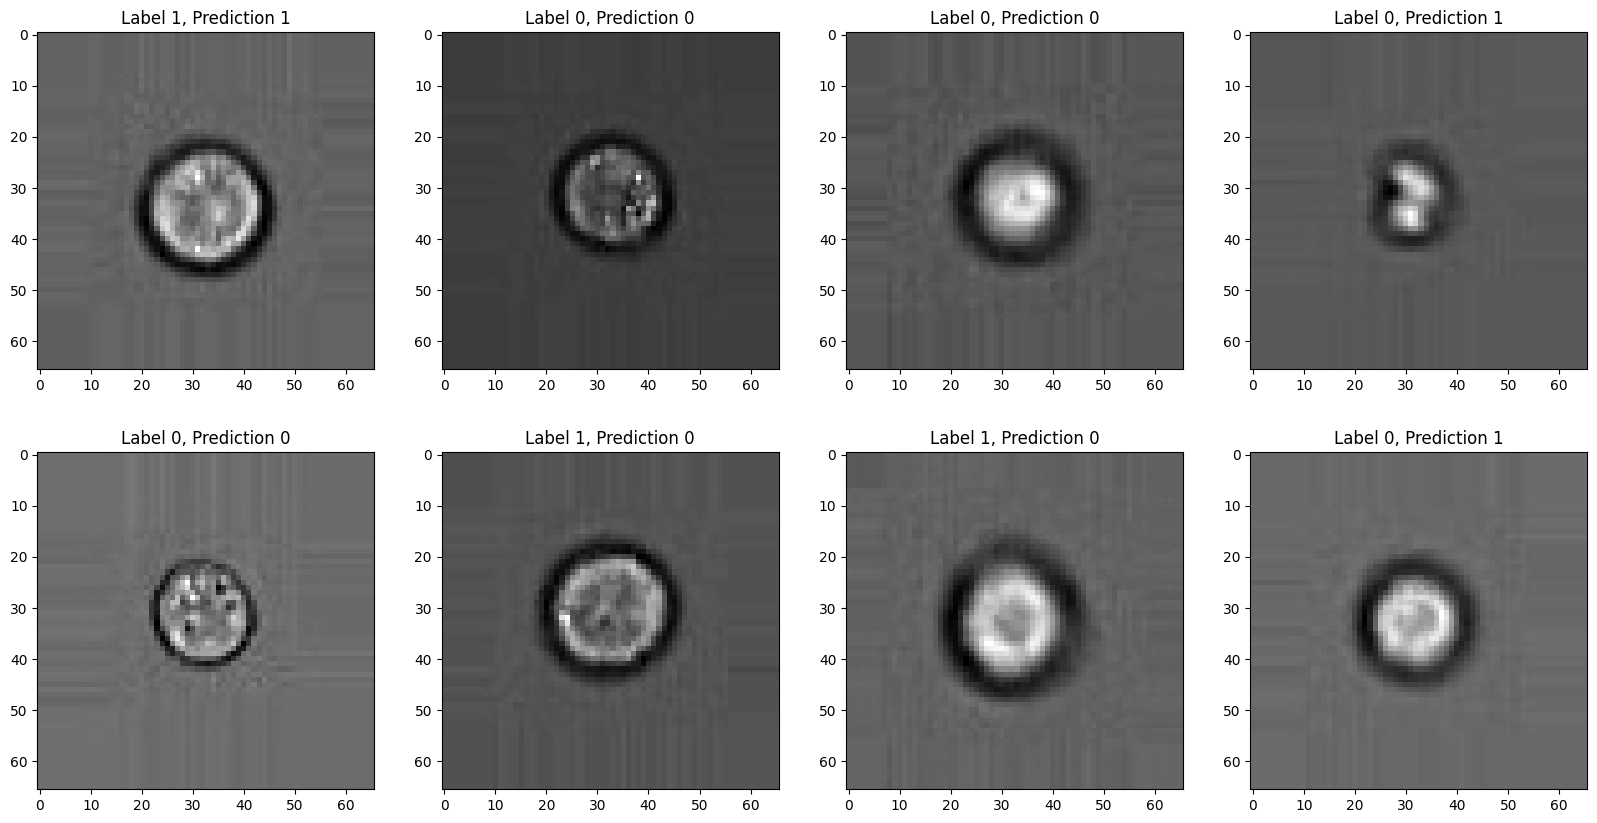

In [39]:
# Visualize some predictions
it = dataset['test'].as_numpy_iterator()

fig, axes = plt.subplots(2, 4, figsize=(20,10))
for i in range(8):
    X_test, y_test = it.next()
    
    # Get an example image
    X_sample = X_test[[i],...]
    
    # Predict the label
    y_pred_linear = linear_classifier.predict(X_sample)
    
    # Display results
    axes.flatten()[i].imshow(X_sample[0], cmap='gray')
    axes.flatten()[i].set_title('Label ' + str(np.argmax(y_test[i])) +', Prediction ' + str(y_pred[i]))

88/88 [==============================] - 0s 804us/step


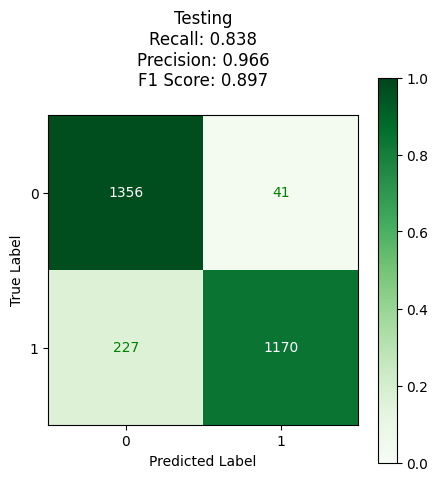

In [40]:
# Generate predictions
test_list = list(dataset['test'].as_numpy_iterator())
X_test = np.concatenate([item[0] for item in test_list], axis=0)
y_test = np.concatenate([item[1] for item in test_list], axis=0)
y_test = np.argmax(y_test, axis=-1)

# Compute linear classifier metrics
y_pred = linear_classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

metrics = benchmark_performance(y_test, y_pred)

plot_metrics(metrics, 'Testing')

#### Task 2.1

Compare and contrast the performance of the first linear classifier that we trained to the version trained in tensorflow.

########################  
######## To Do ###########  
########################  

# Checkpoint

We will come back together as a group to discuss the exercise up to this point before moving on to the next notebook. If you have some extra time, try modifying our tensorflow model to work on 3 or more classes instead of just 2. At minimum, you will need to make the folloing modifications:
- Create a new copy of the dataset that is balanced across all classes
- Modify `create_linear_classifier` to work on 3 classes